In [9]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

In [10]:
E_LEVEL_FREQ = 10 * 2*np.pi
U_LEVEL_FREQ = 5 * 2*np.pi
G_LEVEL_FREQ = 2 * 2*np.pi

In [3]:
def run_2lvl_simulation(initial_state, run_time, num_steps, g0, detuning=0, gamma=0, kappa=0):

    # define characteristics of the atom-cavity system
    e_freq = E_LEVEL_FREQ
    g_freq = G_LEVEL_FREQ
    cav_freq = e_freq - g_freq - detuning * 2*np.pi
    num_photons = 1
    
    # define collapse operator associated with the cavity decay
    photon_c_op = Qobj([
        [0,1,0],
        [0,0,0],
        [0,0,0]
        ])

    # define the collapse operator associated with spontaneous decay of the excited state
    atom_c_op = Qobj([
        [0,0,1],
        [0,0,0],
        [0,0,0]
        ])

    # compile collapse operators into a list with appropriate coefficients
    c_ops = [np.sqrt(kappa)*photon_c_op, np.sqrt(gamma)*atom_c_op]

    # define Hamiltonian
    H = Qobj([
        [0,0,0],
        [0, g_freq + num_photons*cav_freq , -g0],
        [0, -g0, e_freq]])

    # define time grid
    t_steps = np.linspace(0, run_time, num_steps)

    # check normalisation
    norm = sum([abs(coeff)**2 for coeff in initial_state])
    if norm != 1:
        print('WARNING: unnormalised state')
    
    # calculate states that result from cavity dynamics
    result = mesolve(H, initial_state, t_steps, c_ops, [])

    # plot expectations of the measurements of each state
    fig, axes = plt.subplots(1,1)

    g_measure = Qobj([
        [0,0,0],
        [0,1,0],
        [0,0,0]
        ])
    e_measure = Qobj([
        [0,0,0],
        [0,0,0],
        [0,0,1]
        ])

    axes.plot(t_steps, expect(g_measure, result.states))
    axes.plot(t_steps, expect(e_measure, result.states))
    axes.set_xlabel('t')
    axes.set_ylabel('Probability')

    fig.legend(['g','e'])
    return result.states


In [17]:
def run_3lvl_simulation(initial_state, run_time, num_steps, g0, laser_profile, cav_detuning=0, gamma=0, kappa=0):

    # define characteristic frequencies of the atom-cavity system
    g_freq = G_LEVEL_FREQ
    # e_freq = E_LEVEL_FREQ
    # mid_freq = U_LEVEL_FREQ
    e_freq = 1.5*g0
    mid_freq = 0
    
    # define time grid
    t_steps = np.linspace(0, run_time, num_steps)

    # define time-independent part of tghe Hamiltonian
    H0 = Qobj([
        [0,0,0,0],
        [0,cav_detuning * 2*np.pi, 0, -g0],
        [0,0, e_freq - mid_freq, 0],
        [0,-g0, 0, 0]
    ])

    H1 = Qobj([
        [0,0,0,0],
        [0,0,0,0],
        [0,0,-1,-1/2],
        [0,0,-1/2,0]
    ])

    H = [H0, [H1, laser_profile]]

    cavity_c_op = Qobj([
        [0,1,0,0],
        [0,0,0,0],
        [0,0,0,0],
        [0,0,0,0]
    ])

    spont_c_op = Qobj([
        [0,0,0,1],
        [0,0,0,0],
        [0,0,0,0],
        [0,0,0,0]
    ])

    c_ops = [np.sqrt(kappa)*cavity_c_op, np.sqrt(gamma)*spont_c_op]
    
    result = mesolve(H, initial_state, t_steps, c_ops, [])

    e_measure = fock_dm(4,3)
    u_measure = fock_dm(4,2)
    g_measure = fock_dm(4,1)

    # plot expectations of the measurements of each state
    fig, axes = plt.subplots(1,1)
    axes.plot(t_steps, expect(g_measure, result.states))
    axes.plot(t_steps, expect(u_measure, result.states))
    axes.plot(t_steps, expect(e_measure, result.states))
    
    axes.set_xlabel('t')
    axes.set_ylabel('Probability')

    fig.legend(['g','u','e'])
    return result.states
    

In [18]:
q = basis(3,2)
print(q)

g0= 2*np.pi * 1
num_steps = 101
run_time = 1


states = run_2lvl_simulation(q, run_time, num_steps, g0, detuning=0, gamma=0*2*np.pi, kappa=0*2*np.pi)


Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]]


NameError: name 'run_2lvl_simulation' is not defined

1.5606645551297988
Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]
 [0.]]


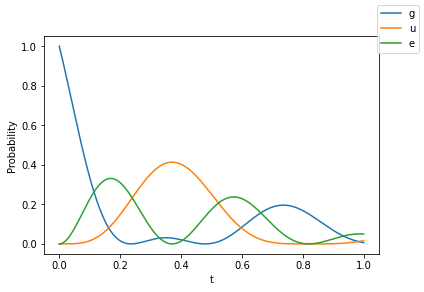

In [19]:
# define detuning of cavity mode
delta_C = 0
delta_L = 0

# define cavity coupleing from input cavity detuning
# g0= (E_LEVEL_FREQ - G_LEVEL_FREQ - delta_C *2*np.pi)/2
# L_FREQ = (E_LEVEL_FREQ - U_LEVEL_FREQ - delta_L*2*np.pi)
g0 = 2*np.pi
L_FREQ = 1.5*g0

num_steps = 1001
run_time = 1
gamma = 0.1*2*np.pi
kappa = 1*2*np.pi
theta = np.arctan(5*2*np.pi/2*g0)
print(theta)

sin_theta = np.sin(theta)
cos_theta = np.cos(theta)
# psi0 = 1*basis(4,2) - 3*L_FREQ/(2*g0)*basis(4,1)
psi0 = basis(4,1)
print(psi0)

def laser_profile(t, arg):
    # laser_freq = (5 - delta_L) * 2*np.pi * (sum([1/k*np.sin(k/2)*np.cos(2*np.pi*k*t) for k in range(1,400)]) +1/4)
    laser_freq = L_FREQ
    return laser_freq


states = run_3lvl_simulation(psi0, run_time, num_steps, g0, laser_profile, cav_detuning=delta_C, gamma=gamma, kappa=kappa)


In [14]:
from qutip import *
print((basis(3,0)*basis(3,0).dag()))

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


1.4142135623730951


In [7]:
print(basis(3,:))

SyntaxError: invalid syntax (Temp/ipykernel_544/3983272627.py, line 1)